# Анализ источников новостей

Цель данного исследования: проанализировать источники новостных лент, сравнить рубрики, подумать над возможностью добавление\удаление категорий для проекта "Радар новостей рунета"

### Summary meduza

1. Датасет содержит 865847 строк, 16 столбцов, из которых пустых 10 столбцов
2. Период дат 2007-03-03 11:17:10 - 2019-05-23 23:45:48
3. Количество топиков 12




In [151]:
%pylab inline
% matplotlib inline
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from string import punctuation
from pymystem3 import Mystem

Populating the interactive namespace from numpy and matplotlib


## gazeta

Загрузим датасет gazeta. Одновременно сделаем преобразование даты из строки

In [152]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [153]:
data_gazeta = pd.read_csv('../../../gazeta.csv',
                      sep=',',
                      index_col=False,
                      escapechar='\\',
                      parse_dates=['date'],
                      date_parser=dateparse,
                      quotechar='\"',
                      error_bad_lines=False)

b'Skipping line 437258: expected 17 fields, saw 20\n'
b'Skipping line 591054: expected 17 fields, saw 20\n'
b'Skipping line 780302: expected 17 fields, saw 20\n'
b'Skipping line 793371: expected 17 fields, saw 20\n'
b'Skipping line 838172: expected 17 fields, saw 20\n'
/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [154]:
# Проверим преобразование
data_gazeta.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                 object
authors                object
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [5]:
data_gazeta.shape

(865847, 16)

In [155]:
# Так выглядет датасет gazeta
data_gazeta.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2008-11-21 15:19:14,https://www.gazeta.ru/news/business/2008/11/21...,-,Бизнес,NaN,Госдума сокращает срок действия ставки экспорт...,Госдума приняла сегодня в первом чтении и сраз...,-,-,-,-,-,-,-,-,-
1,2012-09-27 10:54:51,https://www.gazeta.ru/science/news/2012/09/27/...,-,Наука,NaN,Японские физики повторили синтез 113-го элемента,Японские ученые из физического центра RIKEN за...,-,-,-,-,-,-,-,-,-
2,2015-12-01 15:28:45,https://www.gazeta.ru/army/news/7957079.shtml,-,Армия,NaN,Times: Россия строит новую авиабазу в Сирии,Россия готовится расширить свою военную операц...,-,-,-,-,-,-,-,-,-
3,2013-04-18 16:42:06,https://www.gazeta.ru/travel/news/2013/04/18/n...,-,Новости,NaN,Власти Египта гарантируют безопасность российс...,Египет ждет российских туристов и гарантирует ...,-,-,-,-,-,-,-,-,-
4,2012-09-26 13:54:13,https://www.gazeta.ru/politics/news/2012/09/26...,-,Политика,NaN,Гордума Новочеркасска приняла отставку мэра го...,В Ростовской области депутаты гордумы Новочерк...,-,-,-,-,-,-,-,-,-


In [156]:
# Выясним в каким столбцах есть пустые данные
data_gazeta.isnull().any()

date           False
url            False
edition        False
topics         False
authors         True
title          False
text           False
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

Как видим, в некоторых столбцах вместо значения Nan используется "-", их преобразованием займемся позже. А пока посмотрим строки, в которых пустые тексты новостей

In [157]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_gazeta['authors'].isnull().sum())
data_gazeta[data_gazeta['authors'].isnull()]

Кол-во строк с значением NaN в столбце "authors" =  801505


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2008-11-21 15:19:14,https://www.gazeta.ru/news/business/2008/11/21...,-,Бизнес,NaN,Госдума сокращает срок действия ставки экспорт...,Госдума приняла сегодня в первом чтении и сраз...,-,-,-,-,-,-,-,-,-
1,2012-09-27 10:54:51,https://www.gazeta.ru/science/news/2012/09/27/...,-,Наука,NaN,Японские физики повторили синтез 113-го элемента,Японские ученые из физического центра RIKEN за...,-,-,-,-,-,-,-,-,-
2,2015-12-01 15:28:45,https://www.gazeta.ru/army/news/7957079.shtml,-,Армия,NaN,Times: Россия строит новую авиабазу в Сирии,Россия готовится расширить свою военную операц...,-,-,-,-,-,-,-,-,-
3,2013-04-18 16:42:06,https://www.gazeta.ru/travel/news/2013/04/18/n...,-,Новости,NaN,Власти Египта гарантируют безопасность российс...,Египет ждет российских туристов и гарантирует ...,-,-,-,-,-,-,-,-,-
4,2012-09-26 13:54:13,https://www.gazeta.ru/politics/news/2012/09/26...,-,Политика,NaN,Гордума Новочеркасска приняла отставку мэра го...,В Ростовской области депутаты гордумы Новочерк...,-,-,-,-,-,-,-,-,-
5,2012-09-26 21:11:33,https://www.gazeta.ru/culture/news/2012/09/26/...,-,Культура,NaN,"Министерство культуры назвало фильмы, на котор...",Министерство культуры России определило перече...,-,-,-,-,-,-,-,-,-
6,2011-02-24 16:40:29,https://www.gazeta.ru/news/sport/2011/02/24/n_...,-,Спорт,NaN,Иванов возглавил совет ПБК ЦСКА,Заместитель председателяnправительства РФnСерг...,-,-,-,-,-,-,-,-,-
7,2012-09-27 10:32:37,https://www.gazeta.ru/culture/news/2012/09/27/...,-,Культура,NaN,Коллегия Минкультуры обсудила отказ от бессроч...,Отказ от бессрочных контактов с артистами и вв...,-,-,-,-,-,-,-,-,-
8,2012-09-27 10:36:58,https://www.gazeta.ru/culture/news/2012/09/27/...,-,Культура,NaN,Театр «Россия» на Пушкинской площади открылся ...,Мэр Москвы Сергей Собянин в среду официально о...,-,-,-,-,-,-,-,-,-
9,2012-09-27 11:49:45,https://www.gazeta.ru/culture/news/2012/09/27/...,-,Культура,NaN,Речь Брейвика в суде станет основой театрально...,Немецко-швейцарская театральная труппа намерен...,-,-,-,-,-,-,-,-,-


In [158]:
print('authors: ',data_gazeta['authors'].unique())

authors:  [nan 'Александра Кошкина'
 'Анастасия Берсенева,Максим Солопов,Константин Новиков,Евгений Сафронов'
 ... 'Алина Распоповой' 'Анатолий Караваев,Юрий Воронцов'
 'Евгения Петрова (Сочи)']


In [159]:
print('Процент пустых значений в столбце authors', 
     "{0:.2f}".format(((data_gazeta['authors'].isnull().sum()) *100) / (len(data_gazeta['authors']))) )

Процент пустых значений в столбце authors 92.57


В таблице authors имеется 8% заполненных строк. Удалять столбец нет смысла.

Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [160]:
print('edition: ',data_gazeta['edition'].unique())
print('reposts_fb: ', data_gazeta['reposts_fb'].unique())
print('reposts_vk: ',data_gazeta['reposts_vk'].unique())
print('reposts_ok: ',data_gazeta['reposts_ok'].unique())
print('reposts_twi: ',data_gazeta['reposts_twi'].unique())
print('reposts_lj: ',data_gazeta['reposts_lj'].unique())
print('reposts_tg: ',data_gazeta['reposts_tg'].unique())
print('likes: ',data_gazeta['likes'].unique())
print('views: ',data_gazeta['views'].unique())
print('comm_count: ',data_gazeta['comm_count'].unique())

edition:  ['-']
reposts_fb:  ['-']
reposts_vk:  ['-']
reposts_ok:  ['-']
reposts_twi:  ['-']
reposts_lj:  ['-']
reposts_tg:  ['-']
likes:  ['-']
views:  ['-']
comm_count:  ['-']


### Рубрики gazeta

In [161]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data_gazeta.topics.unique().shape)
data_gazeta['topics'].unique()

Количество рубрик =  (12,)


array(['Бизнес', 'Наука', 'Армия', 'Новости', 'Политика', 'Культура',
       'Спорт', 'Общество', 'Стиль', 'Технологии', 'Авто', 'Мнения'],
      dtype=object)

Все рубрики, с количеством новостей в каждой группе

In [162]:
data_gazeta.groupby('topics')['topics'].count()

topics
Авто           46477
Армия          25522
Бизнес        105386
Культура       42290
Мнения           890
Наука          17258
Новости        13252
Общество      163389
Политика      100214
Спорт         318908
Стиль          12875
Технологии     19386
Name: topics, dtype: int64

In [163]:
data_gazeta.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2008-11-21 15:19:14,https://www.gazeta.ru/news/business/2008/11/21...,-,Бизнес,NaN,Госдума сокращает срок действия ставки экспорт...,Госдума приняла сегодня в первом чтении и сраз...,-,-,-,-,-,-,-,-,-
1,2012-09-27 10:54:51,https://www.gazeta.ru/science/news/2012/09/27/...,-,Наука,NaN,Японские физики повторили синтез 113-го элемента,Японские ученые из физического центра RIKEN за...,-,-,-,-,-,-,-,-,-
2,2015-12-01 15:28:45,https://www.gazeta.ru/army/news/7957079.shtml,-,Армия,NaN,Times: Россия строит новую авиабазу в Сирии,Россия готовится расширить свою военную операц...,-,-,-,-,-,-,-,-,-
3,2013-04-18 16:42:06,https://www.gazeta.ru/travel/news/2013/04/18/n...,-,Новости,NaN,Власти Египта гарантируют безопасность российс...,Египет ждет российских туристов и гарантирует ...,-,-,-,-,-,-,-,-,-
4,2012-09-26 13:54:13,https://www.gazeta.ru/politics/news/2012/09/26...,-,Политика,NaN,Гордума Новочеркасска приняла отставку мэра го...,В Ростовской области депутаты гордумы Новочерк...,-,-,-,-,-,-,-,-,-


### Распределение статей за месяц

Определить период дат 

In [164]:
data_gazeta.sort_values(by='date').head(1)

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
432853,2007-03-03 11:17:10,https://www.gazeta.ru/sport/2007/03/a_1433133....,-,Спорт,Александр Рюхин,Обзор матчей НХЛ,"Сидни Кросби побил очередной рекорд, Павел Дац...",-,-,-,-,-,-,-,-,-


In [165]:
data_gazeta.sort_values(by='date').tail(1)

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
861702,2019-05-23 23:45:48,https://www.gazeta.ru/tech/news/2019/05/23/n_1...,-,Технологии,NaN,Huawei могут включить в торговую сделку между ...,"Глава США ДональдnТрампnзаявил, что китайская ...",-,-,-,-,-,-,-,-,-


Подсчет дубликатов текстов и заголовков. 

Повторяющихся текстов меньше, чем заголовков. Удаляем дубликаты по столбцу text

In [166]:
print('Количество одинаковых текстов', data_gazeta.text.duplicated().sum()), \
print('Количество одинаковых закголовков', data_gazeta.title.duplicated().sum())

data_gazeta = data_gazeta.drop_duplicates(subset='text')

Количество одинаковых текстов 135
Количество одинаковых закголовков 12825


Определим количество статей в среднем, за месяц

In [173]:
data_gazeta['year'] = pd.DatetimeIndex(data_gazeta['date']).year # извлечение года из даты
data_gazeta['month'] = pd.DatetimeIndex(data_gazeta['date']).month # извлечение месяца из даты
# создаем датасет подситывающий количество статей в месяц
df_gazeta = data_gazeta.groupby(by=['year', 'month']).text.nunique().reset_index()
# объединим month и year в один столбец. Добавим 0 к месяцу, если значение однозначное(меньше 10)
df_gazeta['month_year'] = df_gazeta[['year', 'month']].apply(lambda x: '-'.join(['0'+str(x.month) if (x.month)<10 
                                                                                 else str(x.month), str(x.year)]), 
                                                             axis = 1)
df_gazeta[['month_year', 'text']].sort_values(by='text', ascending =True).head()

,month_year,text
2,07-2007,1
3,11-2008,1
4,02-2009,1
5,06-2009,1
6,12-2009,1


In [174]:
# ощутимый прирост количества публикуемых статей наблюдается только с 3его квартала 2012 года
df_gazeta = df_gazeta[df_gazeta['text']>700]

In [175]:
df_gazeta[['month_year', 'text']].count()

month_year    81
text          81
dtype: int64

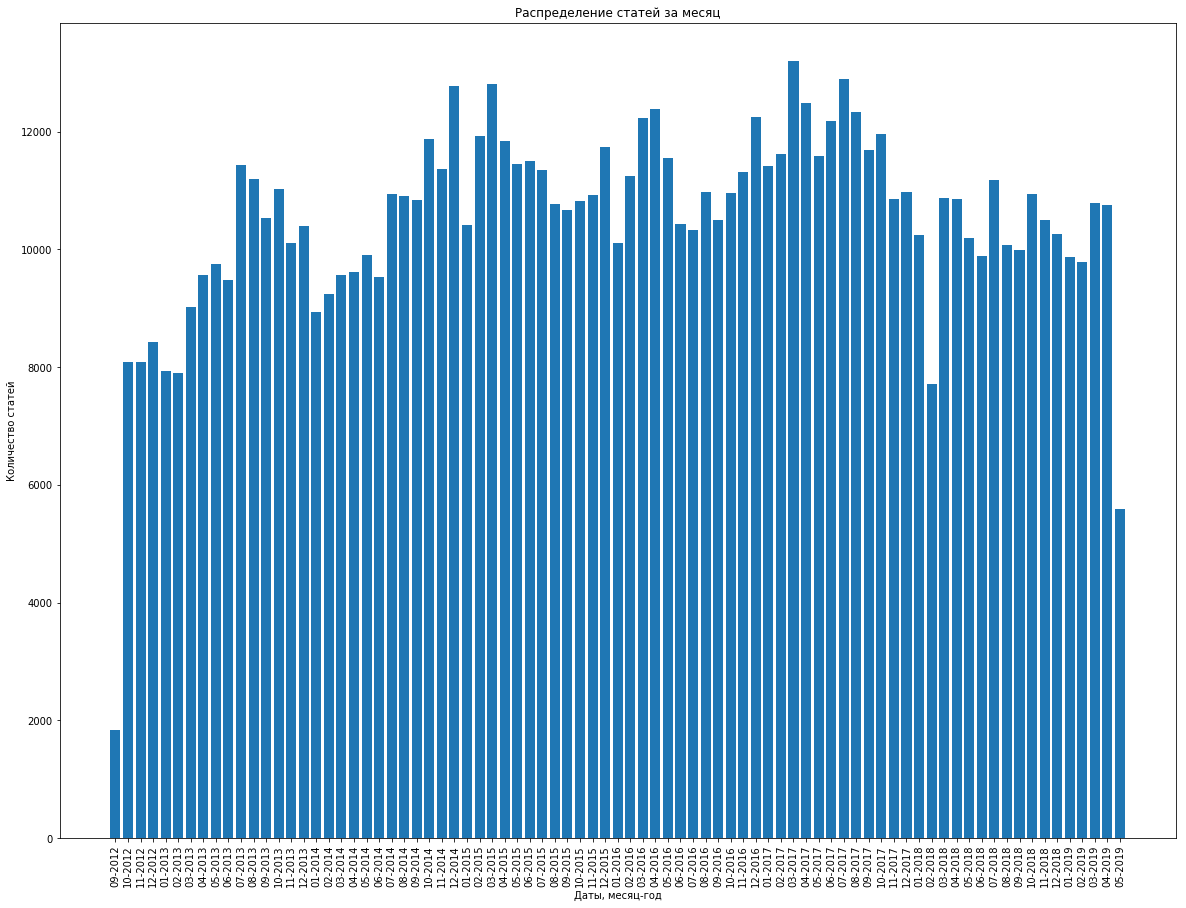

In [176]:
fig, ax = plt.subplots(figsize=(20,15))
plt.bar(x = df_gazeta.month_year, align='center', height = df_gazeta.text.values)
plt.xlabel('Даты, месяц-год')
plt.ylabel('Количество статей')
plt.title('Распределение статей за месяц')
plt.xticks(rotation = 90)
plt.show()

### Частотность слов

Произведем анализ частотности слов датасета. 
1. Для этого уберем из статей стоп-слова.

#### Облако слов

In [122]:
?WordCloud

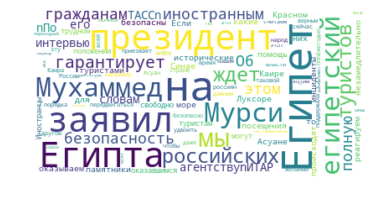

In [184]:
# попробуем на одном примере
text = data_gazeta.text[3]


wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

*Загрузка стоп-слов*

In [135]:
stopwords = open('../stopwords.txt', 'r').read().split('\n')
stopwords += ['br', 'также', 'весь', 'это', 'из', 'какой то', 'млн', 'рубль', 
              'именно', 'поэтому', 'либо', 'пока', 'например', 'поскольку','ru', 'n', 'B'
             ]


#### Лемматизация

In [150]:
# источник https://www.kaggle.com/alxmamaev/how-to-easy-preprocess-russian-text
mystem = Mystem()

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

In [ ]:
%time
data_gazeta['lemma_text'] = data_gazeta.text.apply(lambda x: preprocess_text(x) if pd.isnull(x)==False else '')

In [ ]:
texts = ' '.join(data_gazeta.lemma_text.tolist())

In [ ]:

wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()